In [1]:
import json
import os.path
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
ADJECTIVES_COLORS_ANIMATE = {"black_cat", "brown_dog", "white_horse", "black_bird"}
ADJECTIVES_COLORS_INANIMATE = {"red_bus", "white_truck", "blue_bus", "white_boat"}

ADJECTIVES_SIZES_ANIMATE = {"big_bird", "small_cat", "big_cat", "small_dog"}
ADJECTIVES_SIZES_INANIMATE = {"small_plane", "big_plane", "small_table", "big_truck"}

VERBS_TRANSITIVE = {"eat_man", "ride_woman", "hold_child", "eat_horse"}
VERBS_INTRANSITIVE = {"lie_woman", "fly_bird", "stand_bird", "stand_child"}

all_pairs = ADJECTIVES_COLORS_ANIMATE.union(ADJECTIVES_COLORS_INANIMATE).union(ADJECTIVES_SIZES_ANIMATE)\
                                     .union(ADJECTIVES_SIZES_INANIMATE).union(VERBS_TRANSITIVE).union(VERBS_INTRANSITIVE)

In [3]:
def read_coco_metrics(model_dir, split='test', beam=5, rr=False):
    if rr:
        fn = 'coco.re_ranking.beam_%d.%s' % (beam, split)
    else:
        fn = 'coco.beam_%d.%s' % (beam, split)
    with open(model_dir + fn) as f:
        lines = f.readlines()
    results = dict()
    for line in lines:
        m, s = line.split(': ')
        results[m] = 100*float(s)
    return results

def avg_coco_metrics(metrics_dicts):
    count = len(metrics_dicts)
    results = defaultdict(int)
    for ix, d in metrics_dicts.items():
        for m, s in d.items():
            results[m] += s
    for m in results:
        results[m] /= count
    return results

def read_pair_recalls(mdir, concept_pairs, at=5, split='test', beam=5, rr=False):
    if rr:
        fn = 'recall_%d.%s.re_ranking.beam_%d.%s' % (at, '%s', beam, split)
    else:
        fn = 'recall_%d.%s.beam_%d.%s' % (at, '%s', beam, split)
    basefile = mdir + fn
    results = dict()
    for pair in concept_pairs:
        fn = basefile % pair
        if os.path.isfile(fn):
            with open(fn) as f:
                recall_score = json.load(f)
            results[pair] = recall_score
    return results

def average_recall(recall_scores, min_importance=1):
    pair_recalls_summed = 0
    length = 0

    for i, pair in enumerate(recall_scores.keys()):
        average_pair_recall = np.sum(list(recall_scores[pair]["true_positives"].values())[min_importance - 1:]) / \
                              np.sum(list(recall_scores[pair]["numbers"].values())[min_importance - 1:])
        if not np.isnan(average_pair_recall):
            pair_recalls_summed += average_pair_recall
            length += 1

    recall = 100 * pair_recalls_summed / length
    return recall

In [4]:
split = 'test'
beam = 100
recall_at = 5
basedir = "../experiments/"
model2dirs = {
    'butd': [basedir+'coco_heldout_%d/butd/results/' % d for d in [1,2,3,4]],
    'butd+pos': [basedir+'coco_heldout_%d_pos_inter/butd/results/' % d for d in [1,2,3,4]],
    'butr+rr': [basedir+'coco_heldout_%d/butr/results/' % d for d in [1,2,3,4]],
    'butr+rr+pos': [basedir+'coco_heldout_%d_pos_inter/butr/results/' % d for d in [1,2,3,4]],
    'butr_weight+rr': [basedir+'coco_heldout_%d/butr_weight/results/' % d for d in [1,2,3,4]],
    'butr_weight+rr+pos': [basedir+'coco_heldout_%d_pos_inter/butr_weight/results/' % d for d in [1,2,3,4]],
    'm2': [basedir+'coco_heldout_%d/m2/results/' % d for d in [1,2,3,4]],
    'm2+pos': [basedir+'coco_heldout_%d_pos_inter/m2/results/' % d for d in [1,2,3,4]],
}

In [5]:
model2recalls = {m: {i+1: read_pair_recalls(mdir, all_pairs, recall_at, split, beam, rr=('+rr' in m)) 
                     for i, mdir in enumerate(mdirs)} 
                 for m, mdirs in model2dirs.items()}
model2pair2metrics = dict()
for model, values in model2recalls.items():
    model2pair2metrics[model] = dict()
    for val in values.values():
        for pair, metrics in val.items():
            model2pair2metrics[model][pair] = metrics
            
model2imps = dict()
for model, pair2metrics in model2pair2metrics.items():
    imps = []
    for imp in range(1, 5+1):
        imps.append(average_recall(pair2metrics, imp))
    model2imps[model] = imps

/home/pmh864/libs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


In [6]:
print('\\textbf{Model} & \\textbf{1} & \\textbf{2} & \\textbf{3} & \\textbf{4} & \\textbf{5} \\\\')
for model, pair2metrics in model2pair2metrics.items():
    line = model.upper() + " "
    for imp in range(1, 5+1):
        line += "& %.1f " % average_recall(pair2metrics, imp)
    line += "\\\\"
    print(line)

\textbf{Model} & \textbf{1} & \textbf{2} & \textbf{3} & \textbf{4} & \textbf{5} \\
BUTD & 9.2 & 14.0 & 19.5 & 23.9 & 43.1 \\
BUTD+POS & 11.1 & 17.1 & 22.8 & 29.6 & 48.3 \\
BUTR+RR & 13.7 & 20.4 & 26.1 & 32.5 & 52.2 \\
BUTR+RR+POS & 11.5 & 16.9 & 21.3 & 28.3 & 37.7 \\
BUTR_WEIGHT+RR & 13.5 & 20.4 & 25.6 & 30.1 & 45.2 \\
BUTR_WEIGHT+RR+POS & 15.4 & 22.9 & 28.9 & 34.3 & 48.6 \\
M2 & 10.1 & 15.4 & 20.3 & 21.2 & 38.8 \\
M2+POS & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\


/home/pmh864/libs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


In [7]:
print('\\textbf{Model} & \\textbf{1} & \\textbf{2} & \\textbf{3} & \\textbf{4} & \\textbf{5} \\\\')
for model, imps in model2imps.items():
    line = model.upper() + " "
    for imp in range(1, 5+1):
        line += "& %.1f " % average_recall(pair2metrics, imp)
    line += "\\\\"
    print(line)

\textbf{Model} & \textbf{1} & \textbf{2} & \textbf{3} & \textbf{4} & \textbf{5} \\
BUTD & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
BUTD+POS & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
BUTR+RR & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
BUTR+RR+POS & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
BUTR_WEIGHT+RR & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
BUTR_WEIGHT+RR+POS & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
M2 & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\
M2+POS & 12.1 & 18.3 & 23.6 & 29.8 & 42.4 \\


/home/pmh864/libs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


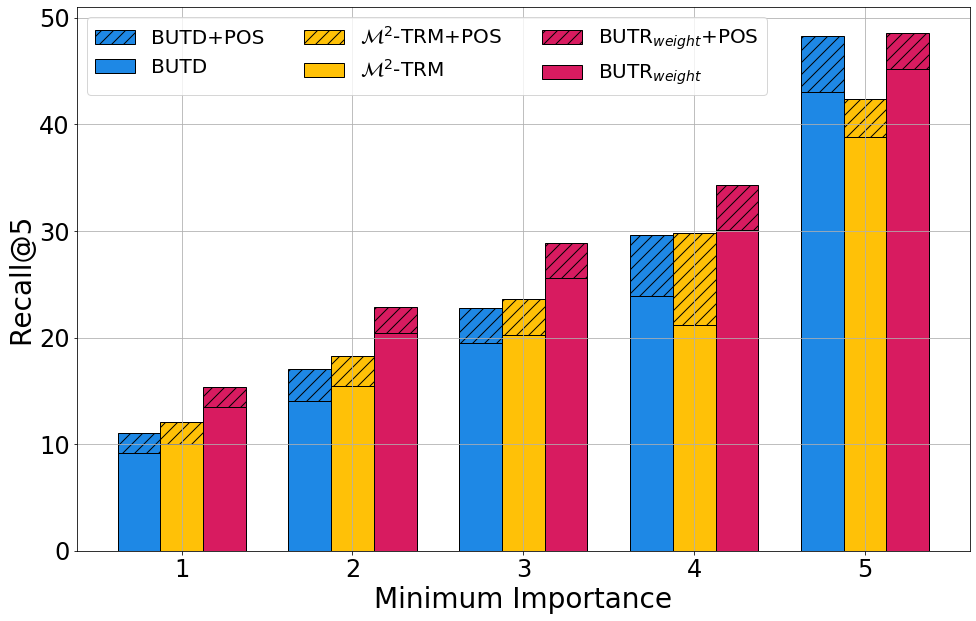

In [8]:
f, ax = plt.subplots(figsize=(16,10))

colors = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(model2imps['butd']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
ax.bar(r1, model2imps['butd+pos'], color=colors[1], width=barWidth, edgecolor='black', label='BUTD+POS', hatch='//')
ax.bar(r1, model2imps['butd'], color=colors[1], width=barWidth, edgecolor='black', label='BUTD')
ax.bar(r2, model2imps['m2+pos'], color=colors[2], width=barWidth, edgecolor='black', label=r'$\mathcal{M}^2$-TRM+POS', hatch='//')
ax.bar(r2, model2imps['m2'], color=colors[2], width=barWidth, edgecolor='black', label=r'$\mathcal{M}^2$-TRM')
ax.bar(r3, model2imps['butr_weight+rr+pos'], color=colors[0], width=barWidth, edgecolor='black', label='BUTR$_{weight}$+POS', hatch='//')
ax.bar(r3, model2imps['butr_weight+rr'], color=colors[0], width=barWidth, edgecolor='black', label='BUTR$_{weight}$')

# Add xticks on the middle of the group bars
ax.set_xlabel('Minimum Importance', fontsize=28)
plt.xticks([r + barWidth for r in range(len(r1))], [1, 2, 3, 4, 5], fontsize=24)
ax.set_ylabel('Recall@5', fontsize=28)
plt.yticks(fontsize=24)

# Create legend & Show graphic
ax.grid()
ax.legend(ncol=3, fontsize=20);
# plt.savefig('min_importance_1.pdf', bbox_inches='tight')